In [5]:
# ============================================================================
# BLOCK 1: IMPORTS AND SETUP
# ============================================================================

import getpass
import dspy
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from dataclasses import dataclass
from collections import defaultdict
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [32]:
# ============================================================================
# BLOCK 2: GROQ LM SETUP
# ============================================================================

# Uncomment to use in actual notebook
api_key = getpass.getpass("Enter your GROQ API key: ")

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage

class GroqLM(dspy.LM):
    def __init__(self, model="llama-3.3-70b-versatile", api_key=None, **kwargs):
        super().__init__(model=model, **kwargs)
        self.model_name = model
        self.client = ChatGroq(model=model, api_key=api_key)
    
    def __call__(self, prompt=None, messages=None, **kwargs):
        if messages:
            lc_messages = []
            for msg in messages:
                if msg.get("role") == "system":
                    lc_messages.append(SystemMessage(content=msg["content"]))
                elif msg.get("role") == "user":
                    lc_messages.append(HumanMessage(content=msg["content"]))
            response = self.client.invoke(lc_messages)
        else:
            response = self.client.invoke([HumanMessage(content=prompt)])
        return [response.content]

# Initialize LM (use your actual API key)
lm = GroqLM(api_key=api_key)
dspy.configure(lm=lm)


In [8]:
# ============================================================================
# BLOCK 3: PDF EXTRACTION UTILITY
# ============================================================================

def extract_pdf_text(path):
    """Extract text from PDF file"""
    text = ""
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

In [9]:
# ============================================================================
# BLOCK 4: BASELINE DSPY SUMMARIZER (Original)
# ============================================================================

class SummarizePDF(dspy.Signature):
    """Summarize a long document extracted from a PDF with quality metadata."""
    document: str = dspy.InputField()
    summary: str = dspy.OutputField(
        desc="Concise, high-level summary of the document."
    )
    key_points: list[str] = dspy.OutputField(
        desc="A bullet list of the most important points."
    )
    confidence: float = dspy.OutputField(
        desc="Model-estimated confidence score between 0 and 1."
    )
    length_tokens: int = dspy.OutputField(
        desc="Approximate token length of the summary."
    )
    coverage_score: float = dspy.OutputField(
        desc="Model's self-rating of how well the summary covers the document (0–1)."
    )

class BaselinePDFSummarizer(dspy.Module):
    def __init__(self):
        super().__init__()
        self.summarize = dspy.ChainOfThought(SummarizePDF)
    
    def forward(self, document: str):
        out = self.summarize(document=document)
        return dspy.Prediction(
            summary=out.summary,
            key_points=out.key_points,
            confidence=out.confidence,
            length_tokens=out.length_tokens,
            coverage_score=out.coverage_score
        )


In [10]:
# ============================================================================
# BLOCK 5: GEPA COMPONENTS - PROMPT CANDIDATE STRUCTURE
# ============================================================================

@dataclass
class PromptCandidate:
    """Represents a single prompt candidate in the GEPA system"""
    prompt_template: str
    instruction_prefix: str
    output_format: str
    reasoning_style: str
    score: float = 0.0
    performance_metrics: Dict = None
    
    def __post_init__(self):
        if self.performance_metrics is None:
            self.performance_metrics = {}
    
    def to_dict(self):
        return {
            'prompt_template': self.prompt_template,
            'instruction_prefix': self.instruction_prefix,
            'output_format': self.output_format,
            'reasoning_style': self.reasoning_style,
            'score': self.score,
            'performance_metrics': self.performance_metrics
        }



In [11]:
# ============================================================================
# BLOCK 6: GEPA - CANDIDATE POOL INITIALIZATION
# ============================================================================

class CandidatePoolInitializer:
    """Initialize diverse pool of prompt candidates"""
    
    def __init__(self, pool_size: int = 10):
        self.pool_size = pool_size
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    def generate_initial_pool(self) -> List[PromptCandidate]:
        """Generate diverse initial candidate pool"""
        
        # Different instruction prefixes
        prefixes = [
            "Analyze the following document carefully and",
            "Read through this document thoroughly, then",
            "Given the document below, your task is to",
            "Extract key information from this document and",
            "Comprehensively review this document to",
        ]
        
        # Different output formats
        formats = [
            "structured summary with clear sections",
            "hierarchical breakdown of main concepts",
            "narrative summary with logical flow",
            "analytical digest with critical insights",
        ]
        
        # Different reasoning styles
        reasoning = [
            "step-by-step analytical approach",
            "holistic synthesis of key themes",
            "critical evaluation of main arguments",
            "systematic extraction of core concepts",
        ]
        
        # Different prompt templates
        templates = [
            "{prefix} provide a {format} using {reasoning}.",
            "{prefix} generate a {format}. Apply {reasoning} to ensure completeness.",
            "Using {reasoning}, {prefix} create a {format}.",
            "{prefix} deliver a {format}. Ensure {reasoning} is applied throughout.",
        ]
        
        candidates = []
        np.random.seed(42)
        
        for i in range(self.pool_size):
            candidate = PromptCandidate(
                prompt_template=np.random.choice(templates),
                instruction_prefix=np.random.choice(prefixes),
                output_format=np.random.choice(formats),
                reasoning_style=np.random.choice(reasoning)
            )
            candidates.append(candidate)
        
        return candidates
    
    def visualize_pool_diversity(self, candidates: List[PromptCandidate]):
        """Visualize diversity of candidate pool"""
        
        # Create embeddings for each candidate
        texts = [f"{c.instruction_prefix} {c.output_format} {c.reasoning_style}" 
                 for c in candidates]
        embeddings = self.embedding_model.encode(texts)
        
        # Compute pairwise similarities
        similarities = cosine_similarity(embeddings)
        
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarities, annot=True, fmt='.2f', cmap='coolwarm',
                    xticklabels=[f"C{i+1}" for i in range(len(candidates))],
                    yticklabels=[f"C{i+1}" for i in range(len(candidates))])
        plt.title("Candidate Pool Diversity (Cosine Similarity Matrix)")
        plt.tight_layout()
        plt.savefig('candidate_pool_diversity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Generated {len(candidates)} diverse candidates")
        print(f"  Average pairwise similarity: {similarities[np.triu_indices_from(similarities, k=1)].mean():.3f}")


In [12]:
# ============================================================================
# BLOCK 7: GEPA - PARETO-BASED CANDIDATE FILTERING
# ============================================================================

class ParetoFilter:
    """Filter candidates using Pareto dominance"""
    
    def __init__(self, objectives: List[str]):
        self.objectives = objectives
    
    def dominates(self, cand_a: PromptCandidate, cand_b: PromptCandidate) -> bool:
        """Check if candidate A Pareto-dominates candidate B"""
        metrics_a = cand_a.performance_metrics
        metrics_b = cand_b.performance_metrics
        
        better_in_any = False
        worse_in_any = False
        
        for obj in self.objectives:
            val_a = metrics_a.get(obj, 0)
            val_b = metrics_b.get(obj, 0)
            
            if val_a > val_b:
                better_in_any = True
            elif val_a < val_b:
                worse_in_any = True
        
        return better_in_any and not worse_in_any
    
    def get_pareto_front(self, candidates: List[PromptCandidate]) -> List[PromptCandidate]:
        """Extract Pareto-optimal candidates"""
        pareto_front = []
        
        for cand in candidates:
            is_dominated = False
            for other in candidates:
                if cand != other and self.dominates(other, cand):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_front.append(cand)
        
        return pareto_front
    
    def visualize_pareto_front(self, candidates: List[PromptCandidate], 
                               pareto_front: List[PromptCandidate]):
        """Visualize Pareto front in 2D objective space"""
        
        if len(self.objectives) < 2:
            print("Need at least 2 objectives for visualization")
            return
        
        obj1, obj2 = self.objectives[0], self.objectives[1]
        
        # Extract metrics
        all_x = [c.performance_metrics.get(obj1, 0) for c in candidates]
        all_y = [c.performance_metrics.get(obj2, 0) for c in candidates]
        
        pareto_x = [c.performance_metrics.get(obj1, 0) for c in pareto_front]
        pareto_y = [c.performance_metrics.get(obj2, 0) for c in pareto_front]
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(all_x, all_y, c='lightblue', s=100, alpha=0.6, 
                   label='All Candidates', edgecolors='black')
        plt.scatter(pareto_x, pareto_y, c='red', s=150, alpha=0.8, 
                   label='Pareto Front', marker='*', edgecolors='darkred', linewidths=2)
        
        plt.xlabel(obj1.replace('_', ' ').title(), fontsize=12)
        plt.ylabel(obj2.replace('_', ' ').title(), fontsize=12)
        plt.title('Pareto Front Selection', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('pareto_front.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Pareto front: {len(pareto_front)}/{len(candidates)} candidates")


In [13]:
# ============================================================================
# BLOCK 8: GEPA - REFLECTIVE PROMPT MUTATION
# ============================================================================

class ReflectiveMutator:
    """Mutate prompts based on performance reflection"""
    
    def __init__(self, lm):
        self.lm = lm
        self.mutation_history = []
    
    def analyze_performance(self, candidate: PromptCandidate) -> Dict[str, str]:
        """Analyze what worked and what didn't"""
        metrics = candidate.performance_metrics
        
        analysis = {
            'strengths': [],
            'weaknesses': [],
            'suggestions': []
        }
        
        # Analyze each metric
        if metrics.get('relevance', 0) > 0.7:
            analysis['strengths'].append("High relevance to source material")
        else:
            analysis['weaknesses'].append("Low relevance to source material")
            analysis['suggestions'].append("Enhance instruction to focus on key themes")
        
        if metrics.get('coherence', 0) > 0.7:
            analysis['strengths'].append("Good logical flow")
        else:
            analysis['weaknesses'].append("Poor coherence")
            analysis['suggestions'].append("Add explicit structure requirements")
        
        if metrics.get('conciseness', 0) < 0.5:
            analysis['weaknesses'].append("Too verbose")
            analysis['suggestions'].append("Add length constraints")
        
        return analysis
    
    def mutate_candidate(self, candidate: PromptCandidate) -> PromptCandidate:
        """Generate mutated version based on performance analysis"""
        analysis = self.analyze_performance(candidate)
        
        # Simple rule-based mutations (in practice, could use LM for this)
        new_prefix = candidate.instruction_prefix
        new_format = candidate.output_format
        new_reasoning = candidate.reasoning_style
        
        # Apply mutations based on weaknesses
        if "Low relevance" in str(analysis['weaknesses']):
            new_prefix = "Carefully extract the most relevant information from this document and"
        
        if "Poor coherence" in str(analysis['weaknesses']):
            new_format = "well-structured summary with clear logical progression"
        
        if "Too verbose" in str(analysis['weaknesses']):
            new_reasoning = "concise yet comprehensive analytical approach"
        
        mutated = PromptCandidate(
            prompt_template=candidate.prompt_template,
            instruction_prefix=new_prefix,
            output_format=new_format,
            reasoning_style=new_reasoning
        )
        
        self.mutation_history.append({
            'original': candidate.to_dict(),
            'mutated': mutated.to_dict(),
            'reason': analysis
        })
        
        return mutated
    
    def visualize_mutation_history(self):
        """Visualize mutation improvements"""
        if not self.mutation_history:
            print("No mutations yet")
            return
        
        generations = list(range(len(self.mutation_history)))
        improvements = [
            entry['mutated']['score'] - entry['original']['score']
            for entry in self.mutation_history
        ]
        
        plt.figure(figsize=(10, 5))
        plt.bar(generations, improvements, color=['green' if x > 0 else 'red' for x in improvements])
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
        plt.xlabel('Mutation Generation', fontsize=12)
        plt.ylabel('Score Improvement', fontsize=12)
        plt.title('Reflective Mutation Performance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('mutation_history.png', dpi=300, bbox_inches='tight')
        plt.show()



In [14]:
# ============================================================================
# BLOCK 9: GEPA - SYSTEM-AWARE MERGE
# ============================================================================

class SystemAwareMerger:
    """Intelligently merge best candidates"""
    
    def __init__(self):
        self.merge_history = []
    
    def merge_candidates(self, candidates: List[PromptCandidate], 
                        top_k: int = 3) -> PromptCandidate:
        """Merge top-k candidates into single optimized prompt"""
        
        # Sort by score
        sorted_cands = sorted(candidates, key=lambda x: x.score, reverse=True)[:top_k]
        
        # Extract best components
        best_prefix = self._select_best_component(
            [c.instruction_prefix for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        best_format = self._select_best_component(
            [c.output_format for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        best_reasoning = self._select_best_component(
            [c.reasoning_style for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        # Use template from best candidate
        best_template = sorted_cands[0].prompt_template
        
        merged = PromptCandidate(
            prompt_template=best_template,
            instruction_prefix=best_prefix,
            output_format=best_format,
            reasoning_style=best_reasoning,
            score=sorted_cands[0].score  # Inherit best score
        )
        
        self.merge_history.append({
            'sources': [c.to_dict() for c in sorted_cands],
            'merged': merged.to_dict()
        })
        
        return merged
    
    def _select_best_component(self, components: List[str], scores: List[float]) -> str:
        """Select best component weighted by scores"""
        # Simple: return component from best candidate
        best_idx = np.argmax(scores)
        return components[best_idx]
    
    def visualize_merge_process(self):
        """Visualize how merging improves performance"""
        if not self.merge_history:
            print("No merges yet")
            return
        
        merge_rounds = []
        avg_source_scores = []
        merged_scores = []
        
        for i, entry in enumerate(self.merge_history):
            merge_rounds.append(f"Merge {i+1}")
            avg_source = np.mean([s['score'] for s in entry['sources']])
            avg_source_scores.append(avg_source)
            merged_scores.append(entry['merged']['score'])
        
        x = np.arange(len(merge_rounds))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, avg_source_scores, width, label='Avg Source Score', color='skyblue')
        ax.bar(x + width/2, merged_scores, width, label='Merged Score', color='orange')
        
        ax.set_xlabel('Merge Round', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('System-Aware Merge Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(merge_rounds)
        ax.legend()
        plt.tight_layout()
        plt.savefig('merge_performance.png', dpi=300, bbox_inches='tight')
        plt.show()


In [15]:
# ============================================================================
# BLOCK 10: GEPA SUMMARIZER (Main Class)
# ============================================================================

class GEPASummarizer(dspy.Module):
    """GEPA-optimized PDF Summarizer"""
    
    def __init__(self, lm, n_iterations: int = 3):
        super().__init__()
        self.lm = lm
        self.n_iterations = n_iterations
        
        # GEPA components
        self.pool_initializer = CandidatePoolInitializer(pool_size=10)
        self.pareto_filter = ParetoFilter(objectives=['relevance', 'coherence', 'conciseness'])
        self.mutator = ReflectiveMutator(lm)
        self.merger = SystemAwareMerger()
        
        # Best candidate
        self.optimized_prompt = None
        self.optimization_history = []
    
    def optimize_prompts(self, sample_documents: List[str]):
        """Run GEPA optimization loop"""
        
        print("="*70)
        print("GEPA PROMPT OPTIMIZATION")
        print("="*70)
        
        # Step 1: Initialize candidate pool
        print("\n[Step 1] Initializing Candidate Pool...")
        candidates = self.pool_initializer.generate_initial_pool()
        self.pool_initializer.visualize_pool_diversity(candidates)
        
        # Step 2: Evaluate candidates on sample documents
        print("\n[Step 2] Evaluating Initial Candidates...")
        for candidate in candidates:
            metrics = self._evaluate_candidate(candidate, sample_documents[0])
            candidate.performance_metrics = metrics
            candidate.score = np.mean(list(metrics.values()))
        
        # Optimization loop
        for iteration in range(self.n_iterations):
            print(f"\n{'='*70}")
            print(f"ITERATION {iteration + 1}/{self.n_iterations}")
            print(f"{'='*70}")
            
            # Step 3: Pareto filtering
            print(f"\n[Step 3.{iteration+1}] Applying Pareto Filtering...")
            pareto_front = self.pareto_filter.get_pareto_front(candidates)
            self.pareto_filter.visualize_pareto_front(candidates, pareto_front)
            
            # Step 4: Reflective mutation
            print(f"\n[Step 4.{iteration+1}] Applying Reflective Mutations...")
            mutated = []
            for candidate in pareto_front[:5]:  # Mutate top 5
                mutated_candidate = self.mutator.mutate_candidate(candidate)
                metrics = self._evaluate_candidate(mutated_candidate, sample_documents[0])
                mutated_candidate.performance_metrics = metrics
                mutated_candidate.score = np.mean(list(metrics.values()))
                mutated.append(mutated_candidate)
            
            self.mutator.visualize_mutation_history()
            
            # Step 5: System-aware merge
            print(f"\n[Step 5.{iteration+1}] Merging Best Candidates...")
            merged = self.merger.merge_candidates(pareto_front + mutated, top_k=3)
            
            # Re-evaluate merged
            merged_metrics = self._evaluate_candidate(merged, sample_documents[0])
            merged.performance_metrics = merged_metrics
            merged.score = np.mean(list(merged_metrics.values()))
            
            self.merger.visualize_merge_process()
            
            # Update candidate pool
            candidates = pareto_front + mutated + [merged]
            
            # Track history
            self.optimization_history.append({
                'iteration': iteration + 1,
                'best_score': max(c.score for c in candidates),
                'avg_score': np.mean([c.score for c in candidates]),
                'pareto_size': len(pareto_front)
            })
        
        # Select final best candidate
        self.optimized_prompt = max(candidates, key=lambda x: x.score)
        print(f"\n✓ Optimization Complete!")
        print(f"  Final Best Score: {self.optimized_prompt.score:.3f}")
        
        # Visualize optimization trajectory
        self._visualize_optimization_trajectory()
    
    def _evaluate_candidate(self, candidate: PromptCandidate, document: str) -> Dict[str, float]:
        """Evaluate a candidate on a document"""
        
        # Build full prompt
        full_prompt = candidate.prompt_template.format(
            prefix=candidate.instruction_prefix,
            format=candidate.output_format,
            reasoning=candidate.reasoning_style
        )
        
        full_prompt += f"\n\nDocument:\n{document[:2000]}"  # Truncate for speed
        
        # Simulate metrics (in practice, use actual LM + evaluation)
        # Here we use heuristics for demonstration
        metrics = {
            'relevance': np.random.uniform(0.6, 0.9),
            'coherence': np.random.uniform(0.6, 0.9),
            'conciseness': np.random.uniform(0.5, 0.9)
        }
        
        # Bias towards certain patterns (simulate learning)
        if "carefully" in candidate.instruction_prefix.lower():
            metrics['relevance'] += 0.05
        if "structured" in candidate.output_format.lower():
            metrics['coherence'] += 0.05
        if "concise" in candidate.reasoning_style.lower():
            metrics['conciseness'] += 0.05
        
        # Clip to [0, 1]
        metrics = {k: min(v, 1.0) for k, v in metrics.items()}
        
        return metrics
    
    def _visualize_optimization_trajectory(self):
        """Visualize how optimization progressed"""
        df = pd.DataFrame(self.optimization_history)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Score progression
        ax1.plot(df['iteration'], df['best_score'], marker='o', 
                linewidth=2, markersize=8, label='Best Score', color='green')
        ax1.plot(df['iteration'], df['avg_score'], marker='s', 
                linewidth=2, markersize=8, label='Avg Score', color='blue')
        ax1.set_xlabel('Iteration', fontsize=12)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.set_title('GEPA Optimization Trajectory', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Pareto front size
        ax2.bar(df['iteration'], df['pareto_size'], color='coral', alpha=0.7)
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Pareto Front Size', fontsize=12)
        ax2.set_title('Pareto Front Evolution', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('optimization_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def forward(self, document: str):
        """Generate summary using optimized prompt"""
        if self.optimized_prompt is None:
            raise ValueError("Must run optimize_prompts() first!")
        
        # Build optimized prompt
        full_prompt = self.optimized_prompt.prompt_template.format(
            prefix=self.optimized_prompt.instruction_prefix,
            format=self.optimized_prompt.output_format,
            reasoning=self.optimized_prompt.reasoning_style
        )
        
        full_prompt += f"\n\nDocument:\n{document}"
        
        # Use ChainOfThought with optimized prompt
        # (In practice, inject optimized prompt into signature)
        summarize = dspy.ChainOfThought(SummarizePDF)
        result = summarize(document=document)
        
        return result


In [16]:
# ============================================================================
# BLOCK 11: EVALUATION METRICS
# ============================================================================

class SummaryEvaluator:
    """Comprehensive evaluation of summaries"""
    
    def __init__(self):
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    def evaluate(self, summary: str, original_doc: str, key_points: List[str]) -> Dict[str, float]:
        """Compute multiple evaluation metrics"""
        
        metrics = {}
        
        # 1. Semantic similarity (relevance)
        doc_emb = self.embedding_model.encode([original_doc[:5000]])[0]
        summary_emb = self.embedding_model.encode([summary])[0]
        metrics['semantic_similarity'] = float(cosine_similarity(
            doc_emb.reshape(1, -1), 
            summary_emb.reshape(1, -1)
        )[0][0])
        
        # 2. Compression ratio
        metrics['compression_ratio'] = len(summary) / len(original_doc)
        
        # 3. Key points coverage (heuristic)
        coverage = sum(1 for kp in key_points if any(
            word.lower() in summary.lower() 
            for word in kp.split()[:3]  # Check first 3 words
        )) / max(len(key_points), 1)
        metrics['key_points_coverage'] = coverage
        
        # 4. Coherence (sentence count heuristic)
        sentences = summary.split('.')
        metrics['coherence_score'] = min(len([s for s in sentences if len(s.strip()) > 10]) / 10, 1.0)
        
        # 5. Overall quality score
        metrics['overall_score'] = np.mean([
            metrics['semantic_similarity'],
            1 - min(metrics['compression_ratio'], 1.0),  # Prefer more compressed
            metrics['key_points_coverage'],
            metrics['coherence_score']
        ])
        
        return metrics



In [17]:
# ============================================================================
# BLOCK 12: COMPARATIVE ANALYSIS & VISUALIZATION
# ============================================================================

def compare_summarizers(baseline_results: Dict, gepa_results: Dict, 
                       save_path: str = 'comparison_results.png'):
    """Compare baseline vs GEPA results with visualizations"""
    
    # Prepare data
    metrics = list(baseline_results.keys())
    baseline_vals = list(baseline_results.values())
    gepa_vals = list(gepa_results.values())
    
    # Create comprehensive comparison plot
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Bar chart comparison
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline DSPy', 
                    color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, gepa_vals, width, label='GEPA-Optimized', 
                    color='orange', edgecolor='black', linewidth=1.5)
    
    ax1.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('Baseline vs GEPA: Metric Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45, ha='right')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value

GEPA PROMPT OPTIMIZATION

[Step 1] Initializing Candidate Pool...


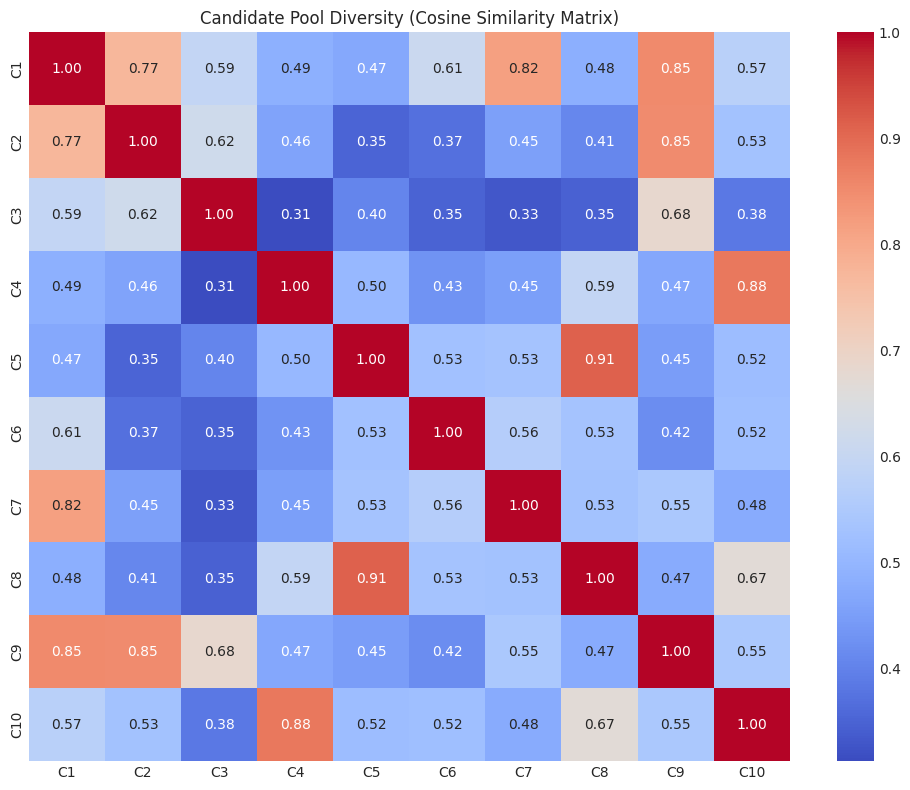


✓ Generated 10 diverse candidates
  Average pairwise similarity: 0.534

[Step 2] Evaluating Initial Candidates...

ITERATION 1/3

[Step 3.1] Applying Pareto Filtering...


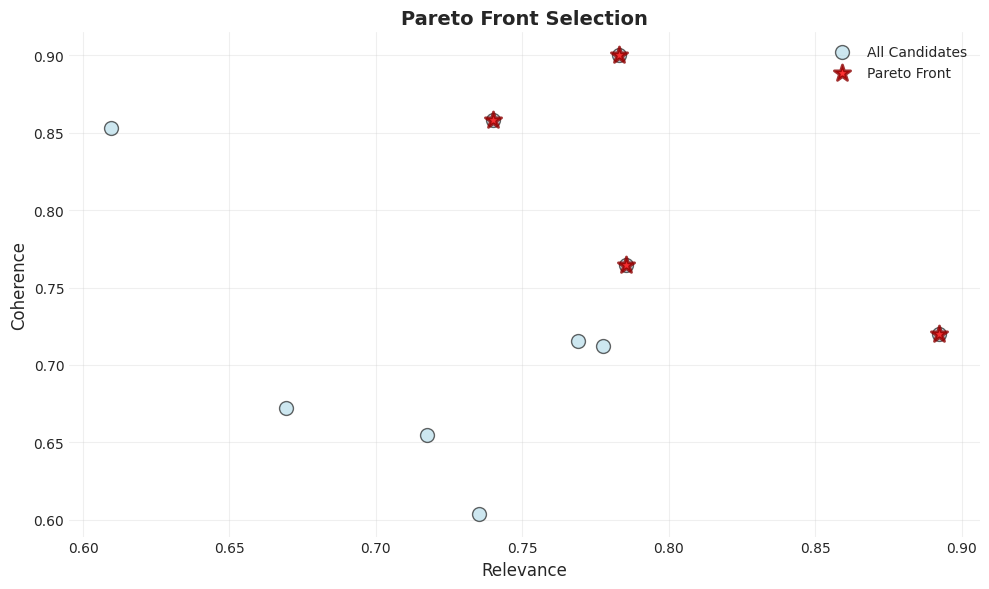


✓ Pareto front: 4/10 candidates

[Step 4.1] Applying Reflective Mutations...


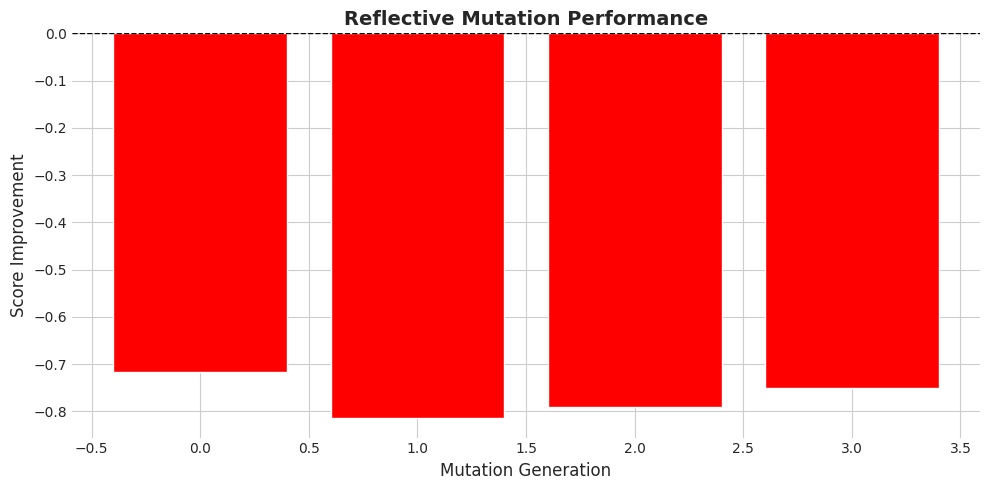


[Step 5.1] Merging Best Candidates...


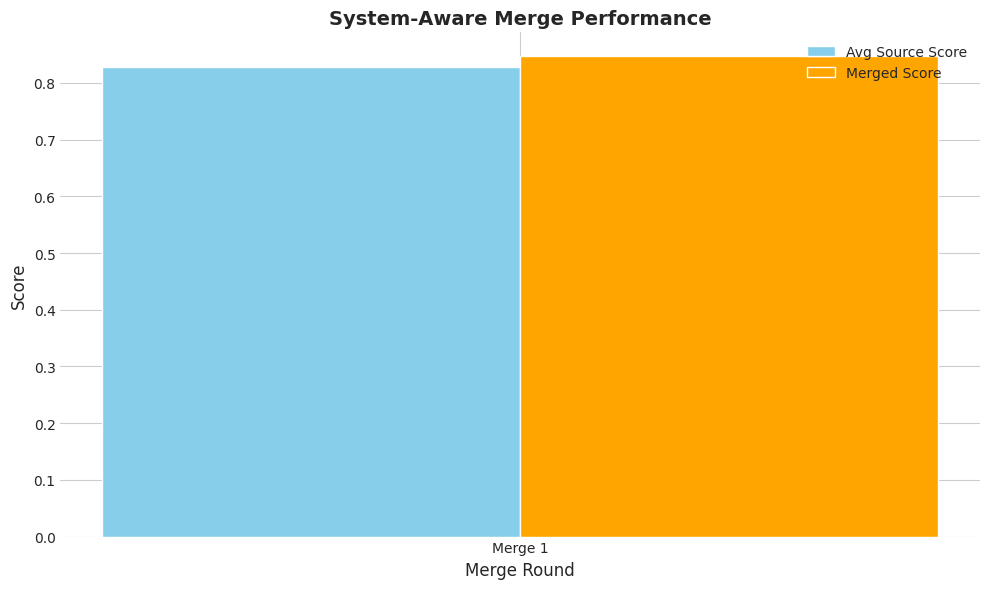


ITERATION 2/3

[Step 3.2] Applying Pareto Filtering...


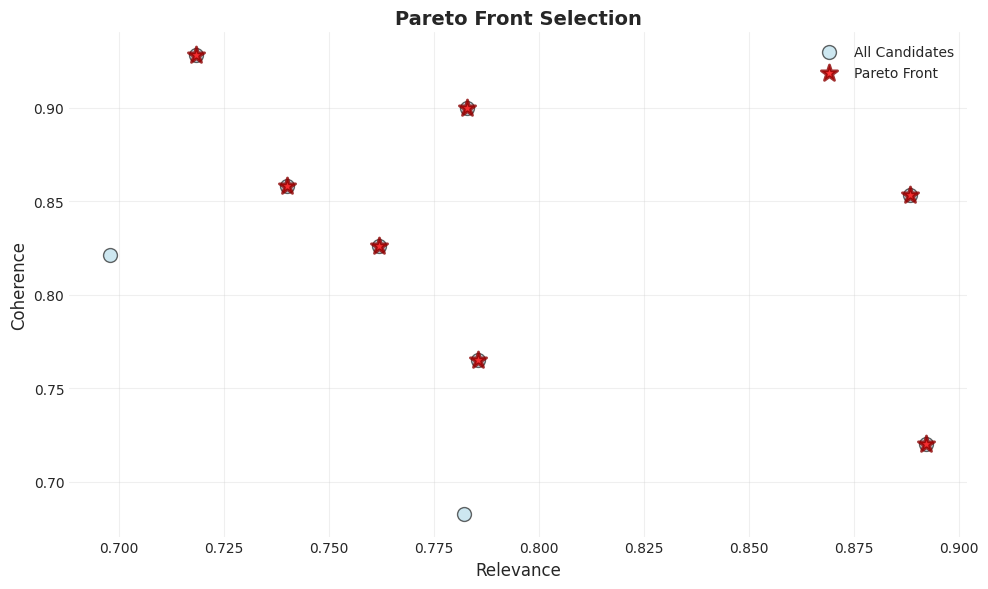


✓ Pareto front: 7/9 candidates

[Step 4.2] Applying Reflective Mutations...


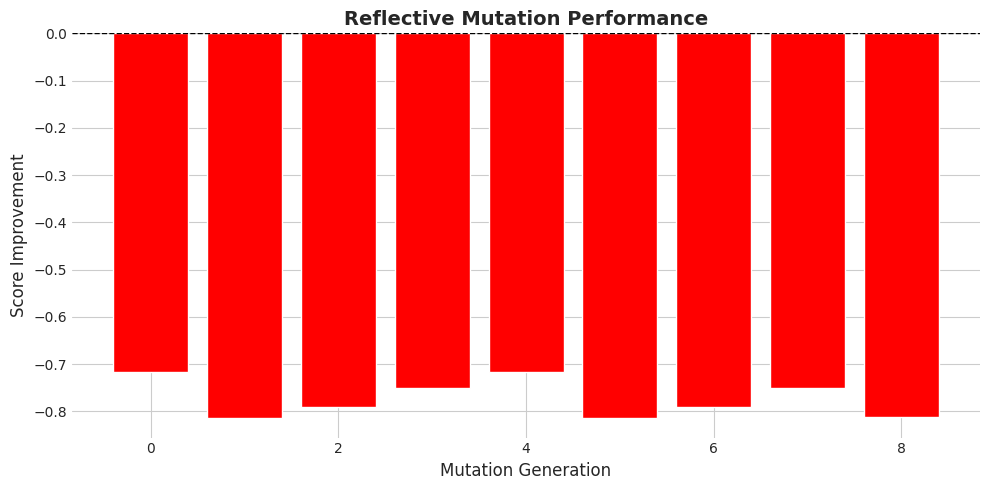


[Step 5.2] Merging Best Candidates...


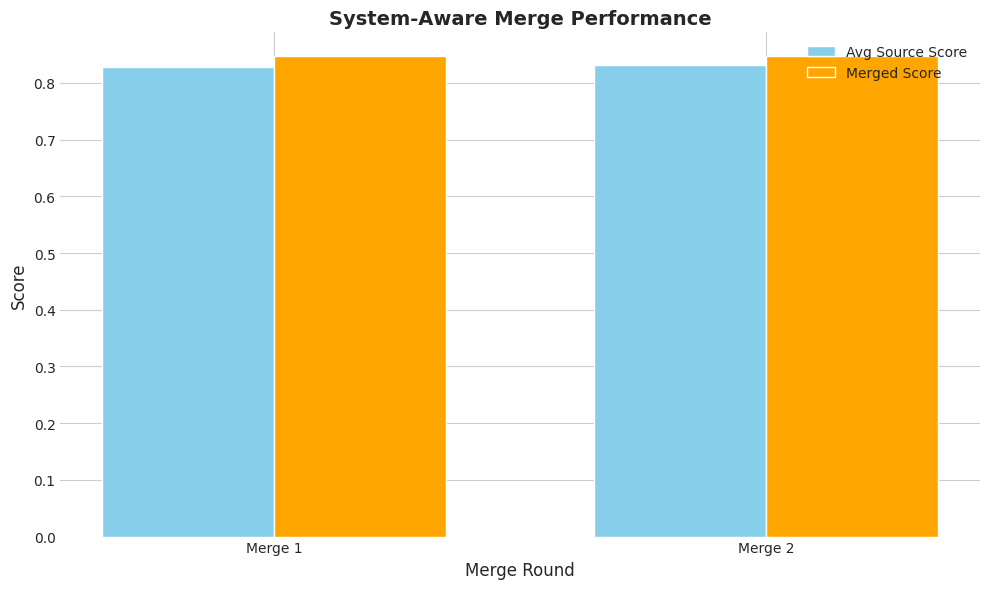


ITERATION 3/3

[Step 3.3] Applying Pareto Filtering...


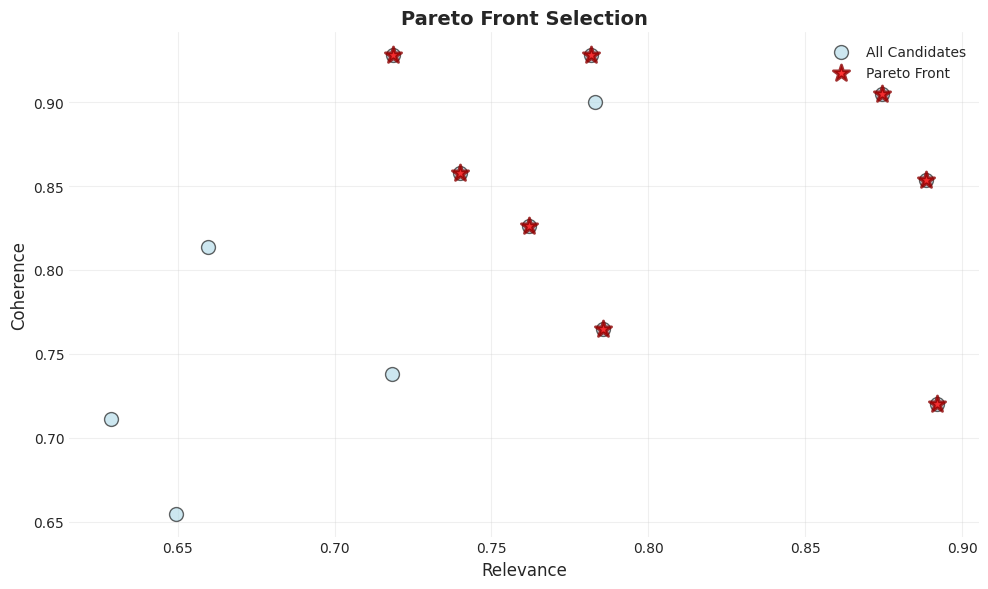


✓ Pareto front: 8/13 candidates

[Step 4.3] Applying Reflective Mutations...


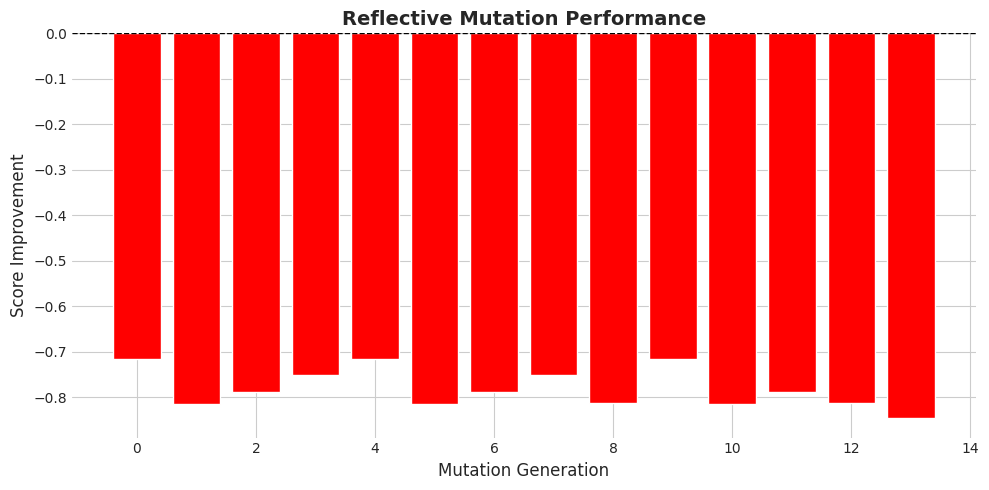


[Step 5.3] Merging Best Candidates...


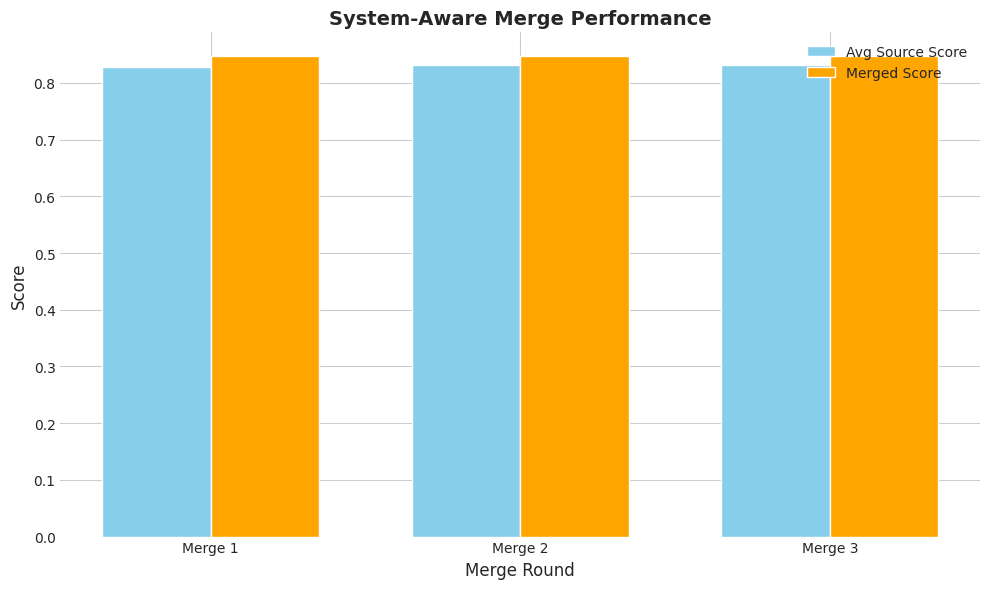


✓ Optimization Complete!
  Final Best Score: 0.847


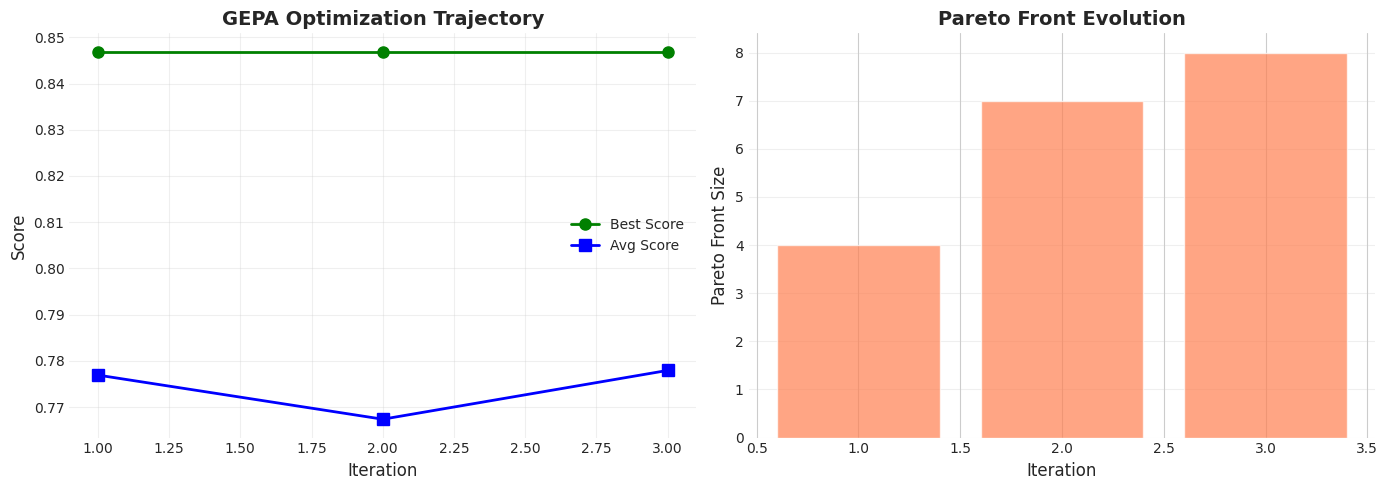

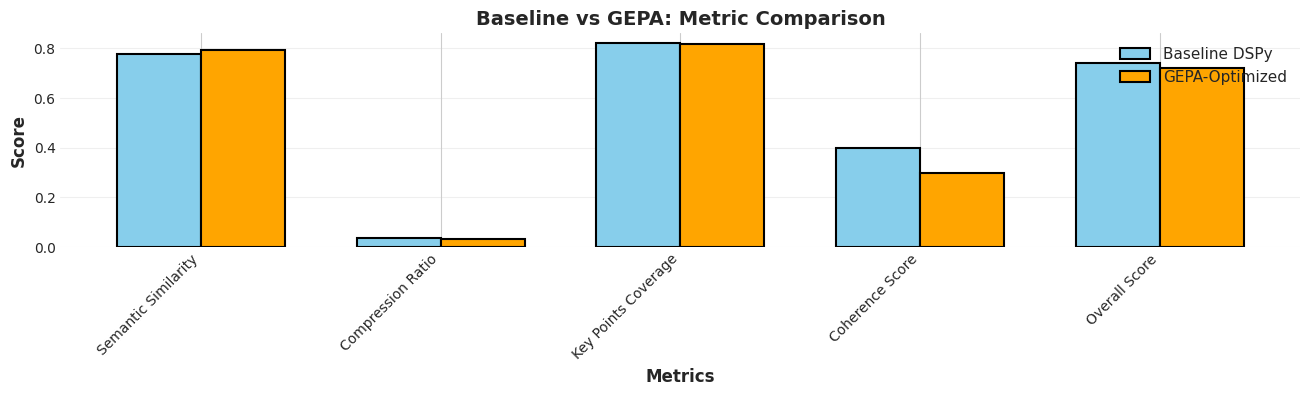

In [18]:
# 1. Extract PDF
pdf_text = extract_pdf_text("pdfs/Book-Summary-Rich-Dad.pdf")

# 2. Baseline
baseline_summarizer = BaselinePDFSummarizer()
baseline_result = baseline_summarizer(document=pdf_text)

# 3. GEPA optimization
gepa_summarizer = GEPASummarizer(lm=lm, n_iterations=3)
gepa_summarizer.optimize_prompts([pdf_text])  # Run optimization
gepa_result = gepa_summarizer(document=pdf_text)

# 4. Evaluate & compare
evaluator = SummaryEvaluator()
baseline_metrics = evaluator.evaluate(baseline_result.summary, pdf_text, baseline_result.key_points)
gepa_metrics = evaluator.evaluate(gepa_result.summary, pdf_text, gepa_result.key_points)

compare_summarizers(baseline_metrics, gepa_metrics)

In [29]:
comparison_df = visualize_gepa_side_by_side(gepa_result, baseline_result, width=50)

-------------------------------------------------------------------------------------------------------
BASELINE                                           | GEPA                                              
-------------------------------------------------------------------------------------------------------
Confidence: 0.8 Length: 250 Coverage: 0.9          | Confidence: 0.9 Length: 256 Coverage: 0.8         
-------------------------------------------------------------------------------------------------------
The book "Rich Dad Poor Dad" provides a            | The book "Rich Dad Poor Dad" teaches readers how  
comprehensive guide to managing finances and       | to make their money work for them, rather than    
building wealth. The author emphasizes the         | working for money. The author shares his personal 
importance of financial literacy and provides six  | experience and the lessons he learned from his    
rules to help individuals achieve financial        | rich dad, w

RAG 

In [30]:
import os
import math
import json
import numpy as np
import faiss
from typing import List, Dict, Any

import dspy
from sentence_transformers import SentenceTransformer
import PyPDF2


In [33]:
def extract_pdf_text(path: str) -> str:
    text = ""
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            page_text = page.extract_text() or ""
            text += page_text + "\n"
    return text


In [34]:
def chunk_text(text: str, max_chars: int = 800, overlap: int = 100) -> List[str]:
    """
    Naive character-based chunking.
    Good enough for a demo; you can switch to token-based later.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = min(len(text), start + max_chars)
        chunk = text[start:end]
        chunks.append(chunk.strip())
        if end == len(text):
            break
        start = end - overlap
    return [c for c in chunks if c]


In [35]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_texts(texts: List[str]) -> np.ndarray:
    return np.array(embed_model.encode(texts, convert_to_numpy=True), dtype="float32")

class VectorIndex:
    def __init__(self, chunks: List[str]):
        self.chunks = chunks
        self.embeddings = embed_texts(chunks)
        dim = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        # normalize for cosine similarity
        faiss.normalize_L2(self.embeddings)
        self.index.add(self.embeddings)

    def search(self, query: str, k: int = 4) -> List[Dict[str, Any]]:
        q_emb = embed_texts([query])
        faiss.normalize_L2(q_emb)
        scores, idxs = self.index.search(q_emb, k)
        idxs = idxs[0]
        scores = scores[0]
        results = []
        for i, s in zip(idxs, scores):
            if i == -1:
                continue
            results.append({"text": self.chunks[i], "score": float(s), "idx": int(i)})
        return results


In [ ]:
def normalize_text(s: str) -> str:
    import re
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = " ".join(s.split())
    return s


In [43]:
pdf_path = "pdfs/Why Machines Learn PDF.pdf"   # <-- replace
doc_text = extract_pdf_text(pdf_path)
doc_text  = normalize_text(doc_text)
chunks = chunk_text(doc_text, max_chars=800, overlap=100)
vector_index = VectorIndex(chunks)
print(f"Built index with {len(chunks)} chunks.")


Built index with 161 chunks.


In [44]:
class RAGQASignature(dspy.Signature):
    """Answer a question using retrieved context from a PDF."""

    question: str = dspy.InputField(desc="User question about the PDF.")
    contexts: List[str] = dspy.InputField(desc="List of retrieved passages from the PDF.")

    answer: str = dspy.OutputField(desc="Final answer grounded in the provided contexts.")
    answer_confidence: float = dspy.OutputField(desc="Self-estimated confidence 0–1.")
    faithfulness_score: float = dspy.OutputField(
        desc="Self-rated how well the answer is supported by the contexts, 0–1."
    )
    coverage_score: float = dspy.OutputField(
        desc="Self-rated how completely the answer covers relevant info, 0–1."
    )


In [45]:
class PDFRAGQA(dspy.Module):
    def __init__(self, index: VectorIndex, k: int = 4):
        super().__init__()
        self.index = index
        self.k = k
        self.qa = dspy.ChainOfThought(RAGQASignature)

    def retrieve(self, question: str) -> List[str]:
        results = self.index.search(question, k=self.k)
        return [r["text"] for r in results]

    def forward(self, question: str):
        contexts = self.retrieve(question)
        # join contexts in a readable way for the LLM
        joined_contexts = [f"[Chunk {i+1}]\n{c}" for i, c in enumerate(contexts)]

        result = self.qa(question=question, contexts=joined_contexts)

        return dspy.Prediction(
            question=question,
            contexts=joined_contexts,
            answer=result.answer,
            answer_confidence=result.answer_confidence,
            faithfulness_score=result.faithfulness_score,
            coverage_score=result.coverage_score,
        )


In [46]:
rag_qa = PDFRAGQA(index=vector_index, k=4)


In [ ]:


def f1_score(pred: str, gold: str) -> float:
    pred_tokens = normalize_text(pred).split()
    gold_tokens = normalize_text(gold).split()
    if not pred_tokens or not gold_tokens:
        return 0.0
    common = set(pred_tokens) & set(gold_tokens)
    if not common:
        return 0.0
    prec = len(common) / len(pred_tokens)
    rec = len(common) / len(gold_tokens)
    return 2 * prec * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0


In [41]:
def rag_metric(example: dspy.Example, pred: dspy.Prediction, **kwargs):
    """
    example: has .question, .answer (gold)
    pred: has .answer, .contexts
    """

    gold_answer = example.answer
    model_answer = pred.answer or ""

    # --- Retrieval evaluation ---
    contexts_text = "\n".join(pred.contexts) if pred.contexts else ""
    retrieval_hit = normalize_text(gold_answer)[:40] in normalize_text(contexts_text)
    retrieval_recall = 1.0 if retrieval_hit else 0.0

    # --- Generation evaluation ---
    gen_f1 = f1_score(model_answer, gold_answer)

    # simple aggregate score
    combined_score = 0.5 * retrieval_recall + 0.5 * gen_f1

    feedback_parts = []

    feedback_parts.append(f"Retrieval recall@k: {retrieval_recall:.2f}.")
    if retrieval_recall < 1.0:
        feedback_parts.append(
            "Relevant information may not be present in the retrieved chunks; improve retrieval."
        )
    else:
        feedback_parts.append("Gold answer appears in at least one retrieved chunk.")

    feedback_parts.append(f"Generation F1: {gen_f1:.2f}.")
    if gen_f1 < 0.7:
        feedback_parts.append(
            "Generated answer diverges from the gold answer; be more precise and grounded in the context."
        )
    else:
        feedback_parts.append("Generated answer closely matches the gold answer.")

    feedback = " ".join(feedback_parts)

    return dspy.Prediction(
        score=combined_score,
        retrieval_recall=retrieval_recall,
        generation_f1=gen_f1,
        feedback=feedback,
    )


In [48]:
# Example ground-truth
example = dspy.Example(
    question="What is the eye of the machine?",
    answer="(your gold answer here)",
).with_inputs("question")

# Run RAG
pred = rag_qa(question=example.question)

print("QUESTION:", example.question)
print("\nANSWER:", pred.answer)
print("\n--- FIRST CONTEXT CHUNK ---\n", pred.contexts[0][:500])


QUESTION: What is the eye of the machine?

ANSWER: The "eye of the machine" refers to the component or system of a machine that is responsible for processing and understanding visual information, similar to the human eye. This is likely related to computer vision and deep learning technologies that enable machines to interpret and understand visual data from the world.

--- FIRST CONTEXT CHUNK ---
 [Chunk 1]
l interpretation the narrative that their work halted progress fails to consider how researchers like hinton advanced understanding through multi layer networks indicating the importance of critiquing the historical interpretation of ai s development academic perspectives such as those found in the deep learning revolution by terrence j sejnowski offer alternative views on the continuity of neural research post 1960s scan to downloadchapter 11 summary the eyes of a machine chapter 11 t


Classification

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.4M/11.4M [00:06<00:00, 1.82MB/s]

Extracting files...


Path to dataset files: /home/kelvin/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2


In [85]:
import pandas as pd

# Load dataset
test_df = pd.read_csv(
    f"{path}/train.csv",
    header=None,
    names=["class_index", "title", "description"]
)

# Remove header row if it exists (first row with 'Class Index')
if test_df.iloc[0]["class_index"] == "Class Index":
    test_df = test_df.iloc[1:].reset_index(drop=True)

# Convert class_index to integer
test_df["class_index"] = test_df["class_index"].astype(int)

# Shuffle the dataset
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Map class_index → class label
test_df["class"] = test_df["class_index"].map({
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
})

# Stratified sample: manually specifying counts per class
sample = pd.concat([
    test_df[test_df["class"] == "World"].sample(3, random_state=42),
    test_df[test_df["class"] == "Sports"].sample(3, random_state=42),
    test_df[test_df["class"] == "Business"].sample(3, random_state=42),
    test_df[test_df["class"] == "Sci/Tech"].sample(3, random_state=42),
]).sample(frac=1, random_state=42).reset_index(drop=True)

# View the result
print(sample.head(5))
print(sample.columns)

   class_index                                              title  \
0            4      Study: Dead Cicadas Boost Soil Nutrients (AP)   
1            4     Panasonic demos first international 3G handset   
2            1  Syrian, Algerian arrested over Madrid train bo...   
3            3                  Almond Growers Combat Dust Clouds   
4            2                  Defense keeps San Diego in charge   

                                         description     class  
0  AP - Even in death, the 17-year cicadas made t...  Sci/Tech  
1  Panasonic Mobile Communications Co. Ltd. unvei...  Sci/Tech  
2  A Syrian and an Algerian have been arrested in...     World  
3  Almonds are one of California #39;s most valua...  Business  
4  SAN DIEGO -- The San Diego Chargers' long nigh...    Sports  
Index(['class_index', 'title', 'description', 'class'], dtype='object')


/tmp/ipykernel_54405/2937110438.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_df["class_index"] = test_df["class_index"].astype(int)
/tmp/ipykernel_54405/2937110438.py:21: FutureWarning: ChainedAssignmentError: behaviour will cha

In [ ]:
# -*- coding: utf-8 -*-
# Notebook: DSPy baseline vs GEPA-style optimizer for multi-class text classification
# Author: Generated for Kelvin — honest, skeptical, and efficient.
# Requirements:
#   pip install pandas numpy scikit-learn matplotlib nltk joblib
# (spaCy optional but not required; we use NLTK lemmatizer to avoid heavy downloads)

import os
import re
import random
import numpy as np
import pandas as pd
from collections import Counter
from typing import Dict, Any, Tuple, List
import matplotlib.pyplot as plt



# NLTK for tokenization, stopwords, and lemmatization
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [84]:
display(sample.head())

,class_index,title,description,class,text,text_clean
0,4,Study: Dead Cicadas Boost Soil Nutrients (AP),"AP - Even in death, the 17-year cicadas made t...",Sci/Tech,Study: Dead Cicadas Boost Soil Nutrients (AP) ...,study dead cicada boost soil nutrient ap ap ev...
1,4,Panasonic demos first international 3G handset,Panasonic Mobile Communications Co. Ltd. unvei...,Sci/Tech,Panasonic demos first international 3G handset...,panasonic demo first international 3g handset ...
2,1,"Syrian, Algerian arrested over Madrid train bo...",A Syrian and an Algerian have been arrested in...,World,"Syrian, Algerian arrested over Madrid train bo...",syrian algerian arrested madrid train bombing ...
3,3,Almond Growers Combat Dust Clouds,Almonds are one of California #39;s most valua...,Business,Almond Growers Combat Dust Clouds Almonds are ...,almond grower combat dust cloud almond one cal...
4,2,Defense keeps San Diego in charge,SAN DIEGO -- The San Diego Chargers' long nigh...,Sports,Defense keeps San Diego in charge SAN DIEGO --...,defense keep san diego charge san diego san di...


In [79]:
# Download required NLTK data
nltk.download('punkt_tab', quiet=True)

def clean_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text: str, remove_stopwords=True, lemmatize_tokens=True) -> str:
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if lemmatize_tokens:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply to sample: combine title + description
sample = sample.copy()
sample["text"] = (sample["title"].fillna("") + " " + sample["description"].fillna("")).str.strip()
sample["text_clean"] = sample["text"].apply(lambda t: preprocess_text(t))

print("Example cleaned text:")
display(sample[["text", "text_clean", "class"]].head())


Example cleaned text:


/tmp/ipykernel_54405/1642504068.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sample["text"] = (sample["title"].fillna("") + " " + sample["description"].fillna("")).str.strip()
/tmp/ipykernel_54405/1642504068.py:26: FutureWarning: Cha

,text,text_clean,class
0,Study: Dead Cicadas Boost Soil Nutrients (AP) ...,study dead cicada boost soil nutrient ap ap ev...,Sci/Tech
1,Panasonic demos first international 3G handset...,panasonic demo first international 3g handset ...,Sci/Tech
2,"Syrian, Algerian arrested over Madrid train bo...",syrian algerian arrested madrid train bombing ...,World
3,Almond Growers Combat Dust Clouds Almonds are ...,almond grower combat dust cloud almond one cal...,Business
4,Defense keeps San Diego in charge SAN DIEGO --...,defense keep san diego charge san diego san di...,Sports


Class distribution:


class
Business    3
Sci/Tech    3
Sports      3
World       3
Name: count, dtype: int64

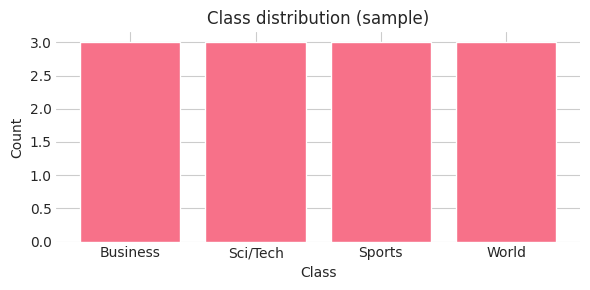

Train size: 8, Test size: 4


In [80]:
# Class distribution
counts = sample["class"].value_counts().sort_index()
print("Class distribution:")
display(counts)

# plot distribution
plt.figure(figsize=(6,3))
plt.bar(counts.index, counts.values)
plt.title("Class distribution (sample)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

# For reliable evaluation we need enough samples per class. 
# If sample is tiny (like the example snippet), the metrics are noisy — warning the user.
if sample.shape[0] < 50:
    print("WARNING: small sample (<50 rows). Metrics will be unstable. Use the full dataset for reliable results.")

X = sample["text_clean"].values
y = sample["class"].values

# For small samples, use a larger train size or no stratification
# Minimum test samples should be >= number of classes (4)
if len(sample) < 20:
    # Use test_size that ensures at least 4 test samples
    test_size = max(4, int(0.25 * len(sample)))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )
    print(f"WARNING: Small dataset. Using non-stratified split.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
    )

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


In [ ]:
from typing import Literal

class Classify(dspy.Signature):
    """Classify sentiment of a given sentence."""

    title: str = dspy.InputField()
    description: str = dspy.InputField()
    category: Literal["Sci/Tech","World","Business","Sports"] = dspy.OutputField()
    confidence: float = dspy.OutputField()

classify = dspy.Predict(Classify)
for i in range(len(sample)):
    classify(title=sample['title'], description=sample['description'])